<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

# TS8: 

**Alumnas:** María Victoria Poric y Agustina Rocío Paolini Rosso  
**Carrera:** Ingeniería Biomédica    
**Materia:** Análisis y Procesamiento de Señales    
**Fecha:** Noviembre 2025 

#### Consigna
Usando el archivo `ecg.mat` que contiene un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:  
- Ruido causado por el movimiento de los electrodos (Alta frecuencia).
- Ruido muscular (Alta frecuencia).
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia). 

a) Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a suavidad de los trazos y nivel isoeléctrico nulo. 

b) ¿Cómo obtuvo dichos valores? Describa el procedimiento para establecer los valores de la plantilla. 

c) Diseñe al menos dos filtros FIR y dos IIR para su comparación. Verifique que la respuesta en frecuencia responda a la plantilla de diseño. 

d) Evalúe el rendimiento de los filtros que haya diseñado: Verifique que filtra las señales interferentes. Verifique que es inocuo en las zonas donde no hay interferentes.

## Introducción
La señal electrocardiográfica (ECG) es un registro eléctrico de la actividad del corazón que proporciona información fundamental sobre el funcionamiento cardíaco. Durante la adquisición de la señal, es común que aparezcan diversas fuentes de interferencia, como el movimiento de los electrodos, el ruido muscular o la deriva de la línea de base inducida por la respiración. Estas contaminaciones pueden dificultar la interpretación de los complejos QRS y de los latidos en general, por lo que resulta esencial aplicar técnicas de filtrado digital que permitan mejorar la calidad de la señal y preservar su morfología fisiológica.

El diseño de filtros digitales permite atenuar selectivamente las frecuencias indeseadas mientras se conserva la información relevante de la señal ECG. Entre los principales tipos de filtros se encuentran los Filtros FIR (Finite Impulse Response) y los Filtros IIR (Infinite Impulse Response).

Los filtros FIR poseen respuesta finita al impulso, lo que garantiza estabilidad inherente y la posibilidad de diseñar filtros con fase lineal, preservando la forma de los complejos QRS. Entre los métodos más utilizados para su diseño se encuentran el método de ventanas, los cuadrados mínimos y el método Parks–McClellan o Remez, que permite obtener un filtrado equiripple optimizado.

Por otro lado, los filtros IIR presentan respuesta infinita al impulso, lo que les permite lograr una mayor selectividad con órdenes más bajos en comparación con los FIR. Su diseño requiere atención para garantizar la estabilidad y minimizar la distorsión de fase. Las aproximaciones más comunes incluyen Butterworth, que proporciona máxima planicidad en la banda pasante; Chebyshev, que ofrece mayor atenuación en la banda de rechazo a cambio de ondulación controlada; y Cauer (elíptico), que optimiza la transición entre banda pasante y de rechazo.

El presente trabajo tiene como objetivo diseñar y comparar filtros FIR e IIR que atenúen las interferencias presentes en un registro de ECG obtenido durante una prueba de esfuerzo. Se busca que la señal filtrada conserve la morfología de los latidos, los niveles isoeléctricos se mantengan estables y se reduzcan las interferencias de alta y baja frecuencia, evaluando la eficacia de cada tipo de filtro mediante análisis de la señal filtrada en regiones con y sin ruido.

## Análisis y resultados

A continuación, se explicará el desarrollo de esta tarea. En primer lugar se diseñó la plantilla de diseño de la siguiente manera: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
from pytc2.sistemas_lineales import plot_plantilla
import scipy.io as sio

# Plantilla de diseño
fs = 1000 # Hz
ws1 = 0.1 # Hz
wp1 = 0.8 # Hz
wp2 = 35 # Hz
ws2 = 40 # Hz
WP = [wp1, wp2] # comienzo y fin de la banda de paso
WS = [ws1, ws2] # comienzo y fin de la banda de stop (corresponde a la atenuacion minima y maxima) -- mas grande que la de paso
 
nyq_frec = fs/2
ripple = 1/2 # dB
atenuacion = 40/2 # dB
  
# plantilla normalizada a Nyquist en dB
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ])/nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
 
# convertimos a veces para las funciones de diseño
gains = 10**(gains/20)

#%%
##################
# Lectura de ECG #
##################

##################
## ECG con ruido
##################

# para listar las variables que hay en el archivo
#io.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
cant_muestras = len(ecg_one_lead)

Los valores establecidos para las frecuencias de la banda de stop, las de la banda de paso y frecuencia de muestreo se obtuvieron mediante diferentes pruebas y errores realizadas en clase hasta determinar que estos valores eran los más adecuados para las respectivas bandas. En el caso de la banda de paso, el contenido relevante se dice que está entre 1 y 30-35 Hz, por debajo de los 0,5 Hz deriva de la respiración y el movimiento. Luego, para la banda de stop, se quiere atenuar mucho por debajo de 0,1 Hz ya que evita desplazamientos lentos del electrodo y se quiere ateuar mucho por encima de los 40 Hz, dejando una "zona muerta" antes de empezar la atenuación para estabilizar la transición. Por último, el valor del ripple logra que no se distorsionen las onda P, QRS y T, y la atenuación es suficiente para eliminar EMG y baseline drift sin requerir filtros demasiado altos. 

Finalmente, se normaliza los valores de frecuencia a $[0-1]$, se define la plantilla en dB y la convierte en unidades lineales ya que este es el formato requerido para `firwin2`, `remez` y `fir2`. 

Asimismo, se carga el ECG con ruido para este trabajo.

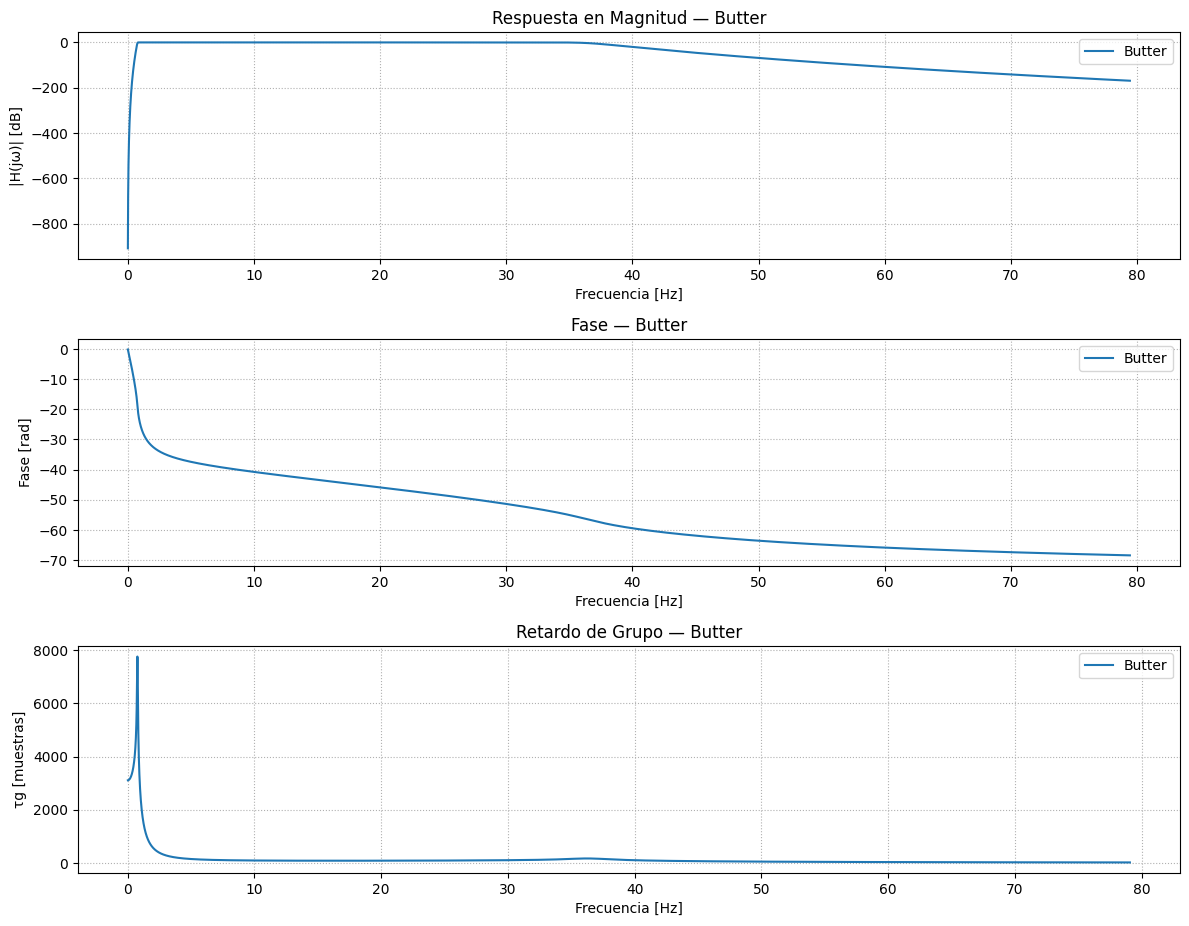

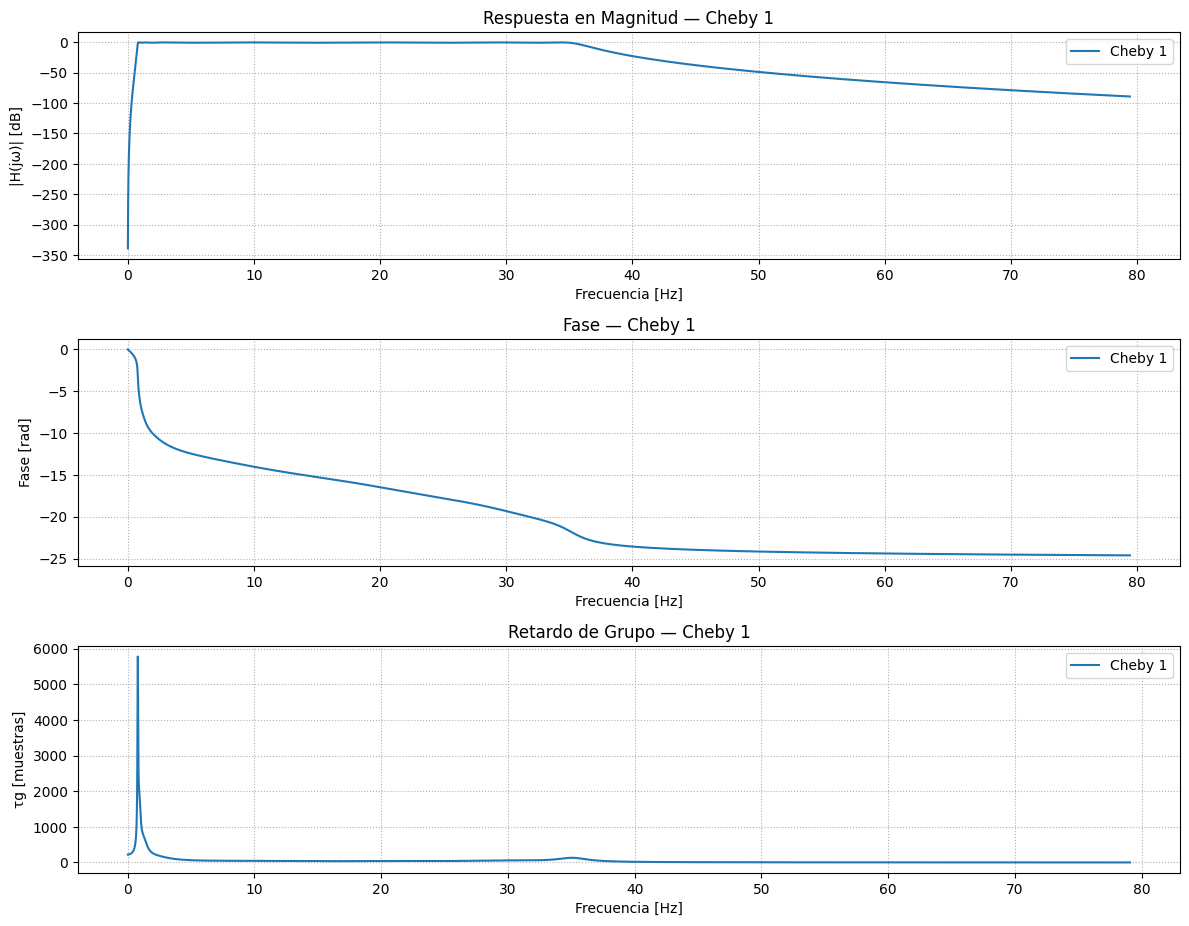

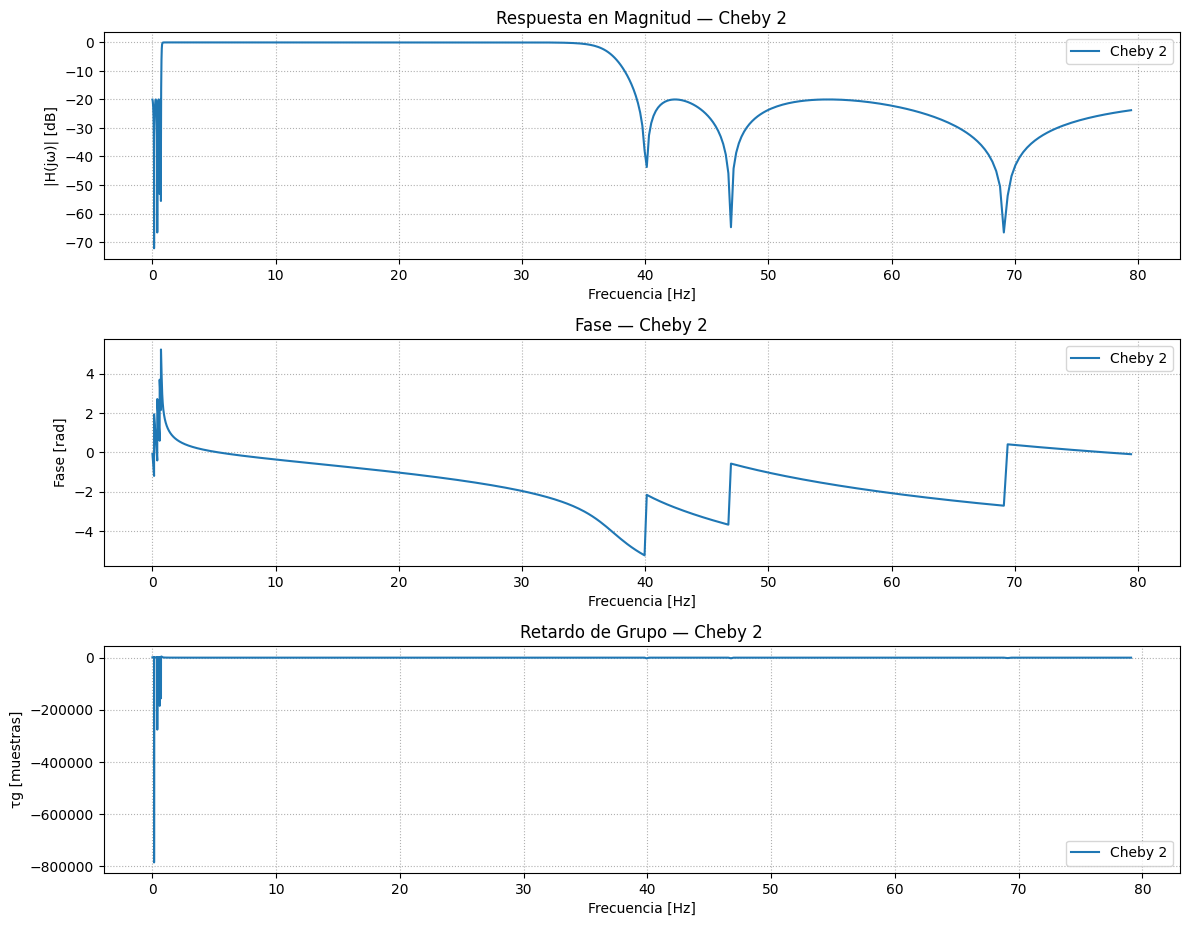

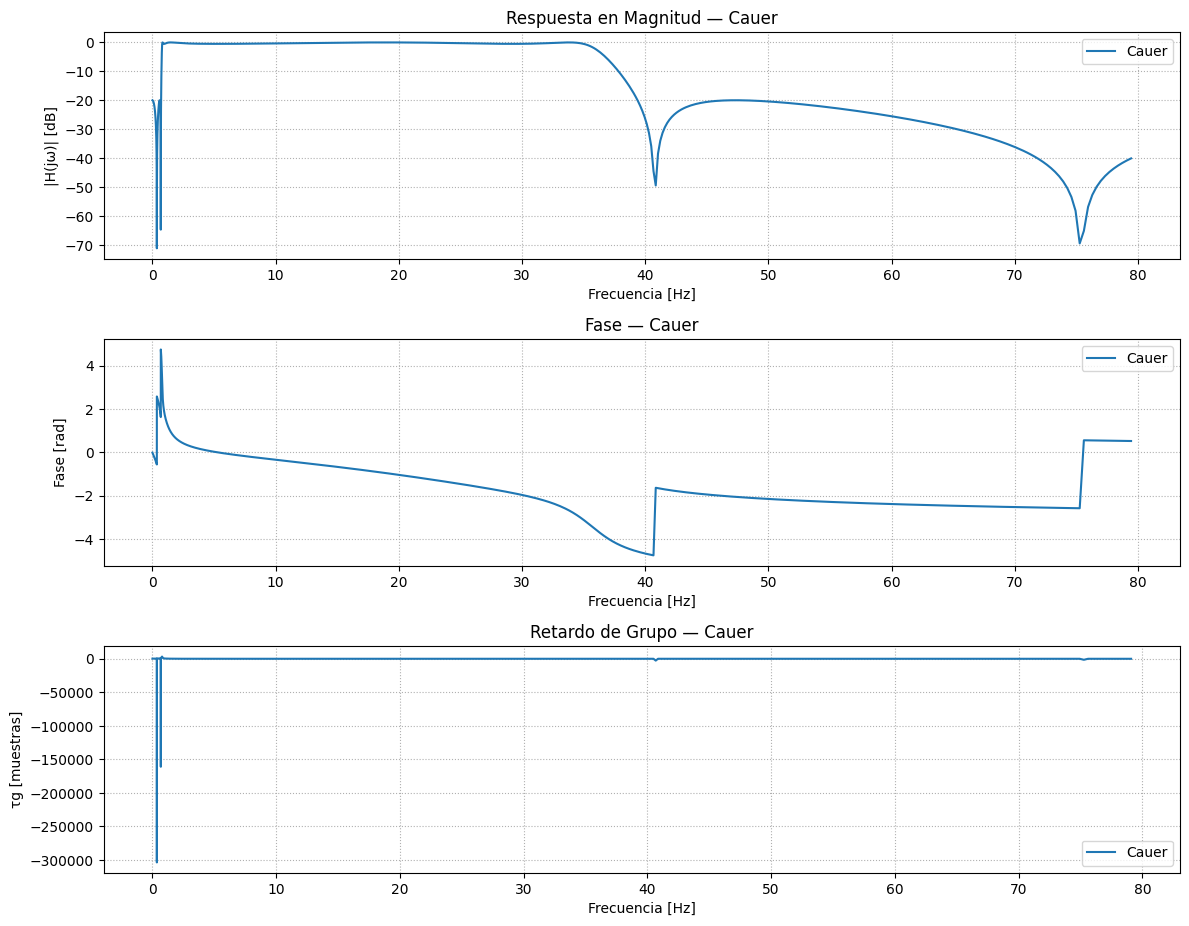

In [4]:
#%%

#Diseño cuatro filtros IIR (aproximaciones de módulo):

f_aprox_butter = 'butter'
f_aprox_ch1 = 'cheby1'
f_aprox_ch2 = 'cheby2'
f_aprox_cauer = 'cauer'

mi_sos_butter = sig.iirdesign(wp=WP, ws=WS, gpass=ripple, gstop=atenuacion, analog=False, ftype=f_aprox_butter, output='sos', fs=fs)
mi_sos_cheby1 = sig.iirdesign(wp=WP, ws=WS, gpass=ripple, gstop=atenuacion, analog=False, ftype=f_aprox_ch1, output='sos', fs=fs)
mi_sos_cheby2 = sig.iirdesign(wp=WP, ws=WS, gpass=ripple, gstop=atenuacion, analog=False, ftype=f_aprox_ch2, output='sos', fs=fs)
mi_sos_cauer = sig.iirdesign(wp=WP, ws=WS, gpass=ripple, gstop=atenuacion, analog=False, ftype=f_aprox_cauer, output='sos', fs=fs)


def plot_sos(sos, fs, name="Filtro IIR",
             filter_type=None, fpass=None, ripple=None,
             fstop=None, attenuation=None):
 
    # RESPUESTA EN FRECUENCIA
    w, h = sig.freqz_sos(sos=sos, fs=fs, worN=np.logspace(-2, 1.9, 2000))

    # FASE Y RETARDO DE GRUPO
    phase = np.unwrap(np.angle(h))
    w_rad = w / (fs/2) * np.pi
    gd = -np.diff(phase) / np.diff(w_rad)

    # GRÁFICAS
    plt.figure(figsize=(12, 12))

    # MAGNITUD
    plt.subplot(4, 1, 1)
    plt.plot(w, 20*np.log10(np.abs(h)), label=name)
    plt.title(f'Respuesta en Magnitud — {name}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('|H(jω)| [dB]')
    plt.grid(True, ls=':')
    plt.legend()

    # FASE
    plt.subplot(4, 1, 2)
    plt.plot(w, phase, label=name)
    plt.title(f'Fase — {name}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Fase [rad]')
    plt.grid(True, ls=':')
    plt.legend()

    # RETARDO DE GRUPO
    plt.subplot(4, 1, 3)
    plt.plot(w[:-1], gd, label=name)
    plt.title(f'Retardo de Grupo — {name}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('τg [muestras]')
    plt.grid(True, ls=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

    
plot_sos(sos=mi_sos_butter, fs=fs, name='Butter', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)
plot_sos(sos=mi_sos_cheby1, fs=fs, name='Cheby 1', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)
plot_sos(sos=mi_sos_cheby2, fs=fs, name='Cheby 2', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)
plot_sos(sos=mi_sos_cauer, fs=fs, name='Cauer', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)

En esta parte del trabajo, se diseñan los filtros IIR, caracterizados por tener una fase no lineal y ser recursivos. Mediante la librería `scipy` se utiliza la función `sig.iirdesign` para mayor practicidad para el diseño de estos filtros. Se utilizan los parámetros previamente definidos. Luego, utilizando `sig.freqz_sos` se calcula la respuesta en frecuencia en formato SOS(Second Order Sections) y con `worN=np.logspace` se generan frecuencias logarítmicas que dan una mejor resolución en frecuencias bajas. 

Se define el retardo del grupo como $$\tau_g = -\,\frac{d \phi(\omega)}{d \omega}$$. Con todo ya definido se procede a graficar la respuesta en frecuencia según el módulo, fase y retardo de grupo de cada tipo de filtro. 

En cuanto al filto Butterworth se puede decir que, para su módulo: 
- Su respuesta en la banda de paso es máximamente plana
- Su respuesta en la banda de rechazo es monotónica, la atenuación aumenta lentamente
- Su frecuencia de corte está definida por -3 dB
- Tiene la transición más lenta de los 4, se vuelve más pronunciada con un orden N creciente

En cuanto al filto Chebysehv(orden 1) se puede decir que, para su módulo: 
- En la banda de paso presenta equiripple con ondulación, es decir, el módulo oscila, con una amplitud pico a pico constante
- Su respuesta en la banda de rechazo es monotónica, la atenuación aumenta más rápido que el Butterworth
- Su frecuencia de corte está definida por la frecuencia de banda de paso $\Omega_p$
- Tiene una transición más abrupta que el Butterworth para un orden N dado

En cuanto al filto Chebyshev(orden 2) se puede decir que, para su módulo: 
- Su respuesta en la banda de paso es monotónica, es similiar a la de Butterworth, casi plana
- Su respuesta en la banda de rechazo presenta equiripple, el módulo oscila dentro de los límites de atenuación $\delta_s$
- Su frecuencia de corte está definida por la frecuencia de banda de rechazo $\Omega_s$
- Tiene una transición más abrupta que el Butterworth

En cuanto al filto Cauer/elíptico se puede decir que, para su módulo: 
- Su respuesta en la banda de paso presenta equiripple con ondulación, es decir, el módulo oscila, con una amplitud pico a pico constante
- Su respuesta en la banda de rechazo presenta equiripple, el módulo oscila dentro de los límites de atenuación
- Su frecuencia de corte está definida por la frecuencia de banda de paso $\Omega_p$
- Tiene la transición más abrupta y el ancho de banda de transición más estrecho para un orden dado

Para los cuatro filtros, la fase tiene un comportamiento no lineal.

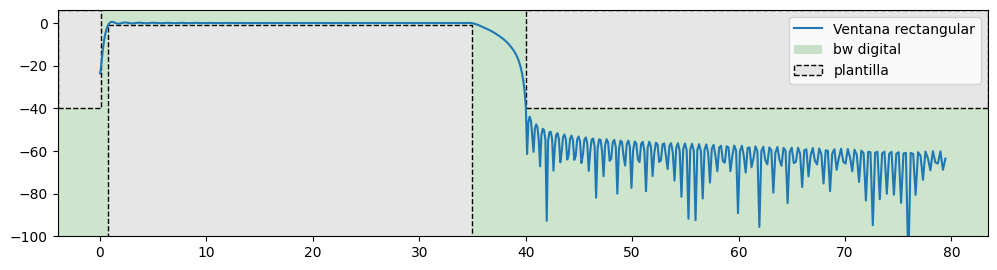

C:\Users\USER\AppData\Local\Temp\ipykernel_7308\3806397910.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


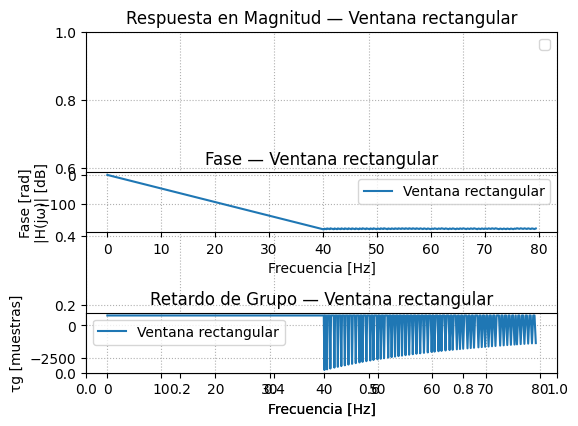

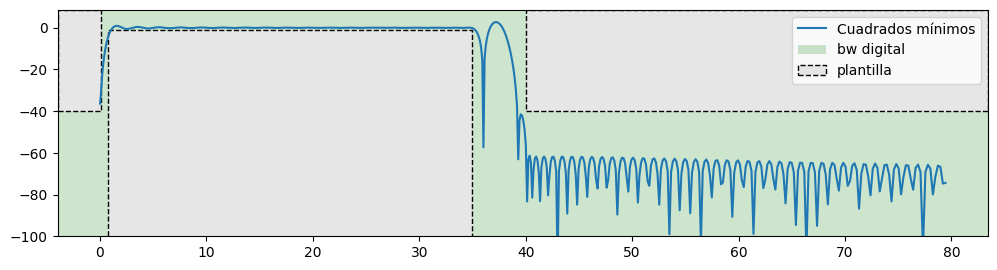

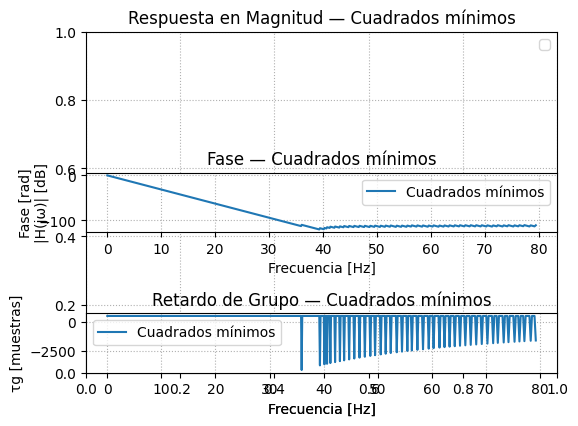

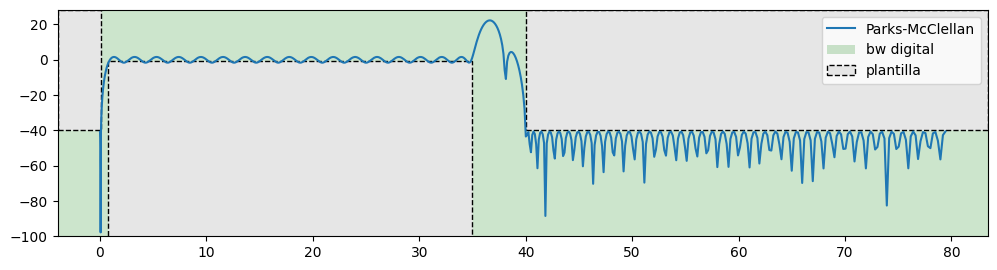

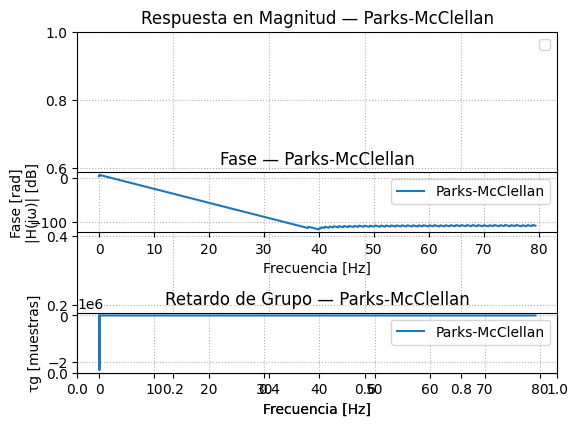

In [5]:
# Diseño de filtros FIR

frecuencias = np.sort(np.concatenate(((0,fs/2), WP, WS)))  #frecuencia va de cero a Nyquist
deseado = [0,0,1,1,0,0]  #Puntos de mi respuesta, respecto a frecuencias(en 0 va 0, en 0.1 va 0, etc.)


#Método ventana
cant_coef_win = 1501
retardo_win = (cant_coef_win - 1)//2
fir_win_rect = sig.firwin2(numtaps = cant_coef_win, freq = frecuencias, gain = deseado, window='boxcar', nfreqs = 2 * cant_coef_win, fs = fs) #Esto es un filtro tipo 2

#Otro método (cuadrados mínimos)
cant_coef_ls = 999 # cant de coeficientes impar
retardo_ls = (cant_coef_ls - 1)//2
frecuencias_ls = [0, ws1, wp1, wp2, ws2, fs/2]
weights_ls = [3, 0.2, 3]
fir_ls = sig.firls(numtaps=cant_coef_ls,
    bands=frecuencias_ls, desired=deseado, weight=weights_ls, fs=fs)

#Método Remez
cant_coef_rem = 999 # cant de coeficientes impar
retardo_rem = (cant_coef_rem - 1)//2
frecuencias_rem = [0, ws1, wp1, wp2, ws2, fs/2]
deseado_rem = [0, 1, 0]
weights_rem = [20, 1, 20]   # stopband más pesado
fir_rem = sig.remez(numtaps=cant_coef_rem, bands=frecuencias_rem, desired=deseado_rem, weight=weights_rem, fs=fs)

def plot_filtro_fir(b, fs, name="Filtro FIR",
                filter_type=None, fpass=None, ripple=None, 
                fstop=None, attenuation=None):
  
    w, h = sig.freqz(b=b, fs=fs, worN=np.logspace(-2, 1.9, 3000))

    phase = np.unwrap(np.angle(h))
    w_rad = w / (fs/2) * np.pi
    gd = -np.diff(phase) / np.diff(w_rad)

    #   GRÁFICAS
    plt.figure(figsize=(12, 10))

    # === MAGNITUD ===
    plt.subplot(3, 1, 1)
    plt.plot(w, 20*np.log10(np.abs(h)), label=name)
    if filter_type is not None:
        plot_plantilla(filter_type, fpass, ripple, fstop, attenuation, fs)
    plt.title(f'Respuesta en Magnitud — {name}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('|H(jω)| [dB]')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    # === FASE ===
    plt.subplot(3, 1, 2)
    plt.plot(w, phase, label=name)
    plt.title(f'Fase — {name}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Fase [rad]')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    # === RETARDO DE GRUPO ===
    plt.subplot(3, 1, 3)
    plt.plot(w[:-1], gd, label=name)
    plt.title(f'Retardo de Grupo — {name}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('τg [muestras]')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_filtro_fir(b=fir_win_rect, fs=fs, name='Ventana rectangular', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)
plot_filtro_fir(b=fir_ls, fs=fs, name='Cuadrados mínimos', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)
plot_filtro_fir(b=fir_rem, fs=fs, name='Parks-McClellan', filter_type='bandpass', fpass=WP, ripple=ripple*2, fstop=WS, attenuation=atenuacion*2)

Luego, se diseñan los filtros FIR. En primer lugar se ordenan las frecuencias ya que así lo piden `firwin2` y `firls`. Se diseña el FIR por ventana, donde `firwin2` toma la respuesta ideal y la aproxima con un FIR aplicando asimilación por ventana. La cantidad de coeficientes elegidos se debe a la prueba y error de distintos valores en clase, y tomar el que mejor se adapte al diseño de la plantilla. El retardo para los FIR lineales está dado por $\tau = \frac{N - 1}{2}$. Luego se diseña el FIR por cuadrados mínimos(`firls`) que minimiza el error cuadrático entre la respuesta real e ideal, luego mediante la asignación numérica de los pesos, se demuestra que es más importante rechazar ruido que tener ripple perfecto en la banda de paso. Por último, se diseña FIR Parks-McClellan mediante `remez` el cual minimiza el error máximo, produciendo filtros óptimos en el sentido del equiripple. Se les dan pesos fuertes en la banda de stop y débil en la banda de rechazo, lo cual fuerza ripple muy bajo en la banda de stop. 

Analizando un poco los distintos filtros FIR y su diseño podemos decir que, para el caso del FIR por ventanas:
- El criterio de diseño consiste en modular o truncar la respuesta al impuslo ideal($h_ideal [n]$) multiplicandola por una ventana $w[n]$
- La respuesta $H(\omega)$ es la convolución en frecuencia de $H_ideal(\omega)$ y la transformada de la ventana $W(\omega)$
- Presenta ondulación (ripple) no uniforme. Hay una relación inversa fundamental: si el lóbulo principal es más estrecho (transición más rápida), los lóbulos laterales son más altos (menor atenuación)
- El ancho de transición depende de la longitud $N$. El ancho de lóbulo principal de $W(\omega)$ determina $\Delta\omega$. Aumentar $N$ reduce $\Delta\omega$
- La atenuación mínima($\delta_s$) generalmente es fija, determinada por la ventana elegida e independiente de la longitud $N$

Para el FIR de cuadrados mínimos:
- El criterio de diseño consiste en minimizar el error cuadrado total entre la respuesta real $H(\omega)$ y la respuesta deseada $H_d(\omega)$ en un conjunto de puntos o rangos de frecuencia
- La respuesta se acerca a la deseada, minimizando el promedio del error cuadrado
- La ondulación depende de la ponderación aplicada, puede no ser uniforme
- Mantenimiento del ancho de banda y transición basado en la minimización del error
- La atenuación mínima puede ser controlada mediante ponderación

Por último, para el FIR de Parks-McClellan:
- El criterio de diseño consiste en minimizar el error máximo ponderado entre $H(\omega)$ y $H_d(\omega)$ en las bandas de interés
- Presenta equirriple. Todas las ondulaciones en la banda de paso y banda de rechazo son de la misma magnitud
- Ondulación uniforme, todos los máximos de error son iguales
- El ancho de transición es el más abrupto (más estrecho) de todos para un orden N dado
- Cumple exactamente con la $\delta_s$ especificada con el orden más bajo posible

La característica más importante de estos filtros es que todos presentan fase lineal y por ende retardo constante. La elección entre estos tres métodos FIR no altera la deseada propiedad de fase lineal, sino que define el mecanismo de optimización para lograr la mejor aproximación a la magnitud ideal. 

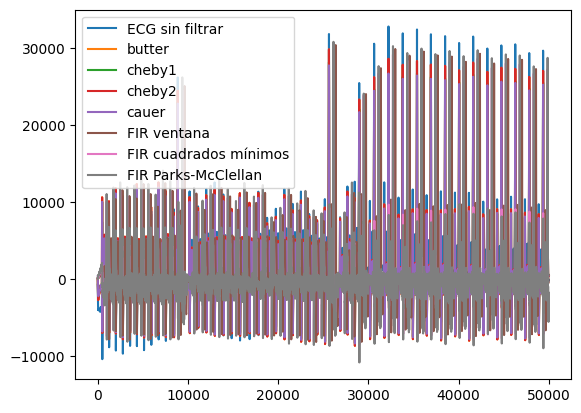

In [6]:
ecg_filt_win = sig.lfilter(b = fir_win_rect, a = 1, x = ecg_one_lead)
ecg_filt_ls = sig.lfilter(b = fir_ls, a = 1, x = ecg_one_lead)
ecg_filt_rem = sig.lfilter(b = fir_rem, a = 1, x = ecg_one_lead)

ecg_filt_butter = sig.sosfiltfilt(mi_sos_butter, ecg_one_lead)
ecg_filt_cheby1 = sig.sosfiltfilt(mi_sos_cheby1, ecg_one_lead)
ecg_filt_cheby2 = sig.sosfiltfilt(mi_sos_cheby2, ecg_one_lead)
ecg_filt_cauer = sig.sosfiltfilt(mi_sos_cauer, ecg_one_lead)

plt.figure()

plt.plot(ecg_one_lead[:50000], label = 'ECG sin filtrar')
plt.plot(ecg_filt_butter[:50000], label = 'butter')
plt.plot(ecg_filt_cheby1[:50000], label = 'cheby1')
plt.plot(ecg_filt_cheby2[:50000], label = 'cheby2')
plt.plot(ecg_filt_cauer[:50000], label = 'cauer')
plt.plot(ecg_filt_win[:50000], label = 'FIR ventana')
plt.plot(ecg_filt_ls[:50000], label = 'FIR cuadrados mínimos')
plt.plot(ecg_filt_rem[:50000], label = 'FIR Parks-McClellan')

plt.legend()

En esta parte del trabajo se observa el ECG sin filtrar junto a la señal filtrada con los distintos filtros diseñados. 

Se observa que: el QRS del ECG es muy angosto y abrupto. Los filtros IIR suaizan el QRS, reducen un poco su amplitud e introducen un poco de distorsión de fase porque no son lineales en fase, lo que produce un QRS un poco desplazado y deformado. El FIR Parks-McClellan y FIR de cuadrados mínimos perseveran mejor la forma. El FIR de ventana muestra más ripple.

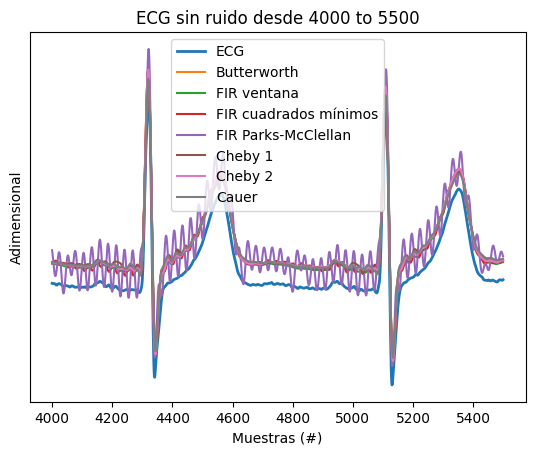

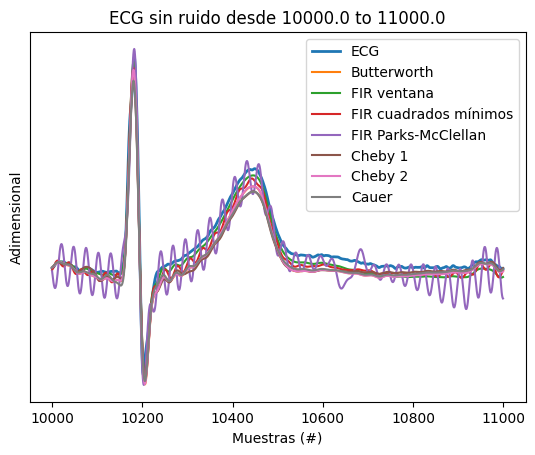

In [7]:
###################################
# Regiones de interés sin ruido #
###################################
 
regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_butter[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ecg_filt_win[zoom_region + retardo_win], label='FIR ventana')
    plt.plot(zoom_region, ecg_filt_ls[zoom_region + retardo_ls], label='FIR cuadrados mínimos')
    plt.plot(zoom_region, ecg_filt_rem[zoom_region + retardo_rem], label='FIR Parks-McClellan')
    plt.plot(zoom_region, ecg_filt_cheby1[zoom_region], label='Cheby 1')
    plt.plot(zoom_region, ecg_filt_cheby2[zoom_region], label='Cheby 2')
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='Cauer')
    
    plt.title('ECG sin ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

La elección de estas zonas sin ruido resultó del análisis visual de la señal ECG completa. 

Se observa que todos los filtros suavizan de manera muy parecida, esto se debe a que no hay componentes de alta frecuencia, el ECG en esta parte es lento y la fase es de menor importancia cuando la señal no cambia rápido. El FIR ventana sigue mostrando más ripple, tiene pequeñas ondulaciones sistemáticas. Los IIR están muy juntos ya que son todos pasa-banda, de orden similar y están bien ajustados en frecuencia. El FIR Parks-McClellan y FIR de cuadrados mínimos son los más suaves. 

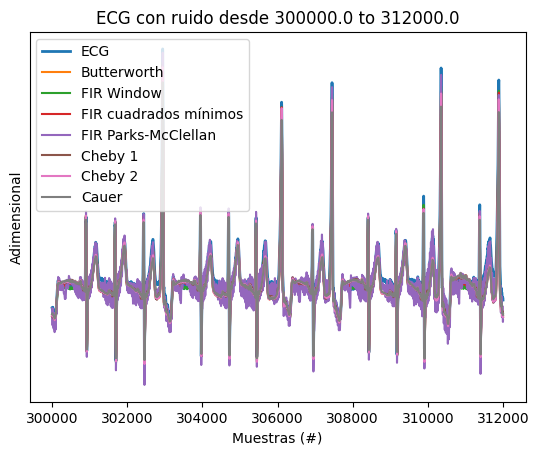

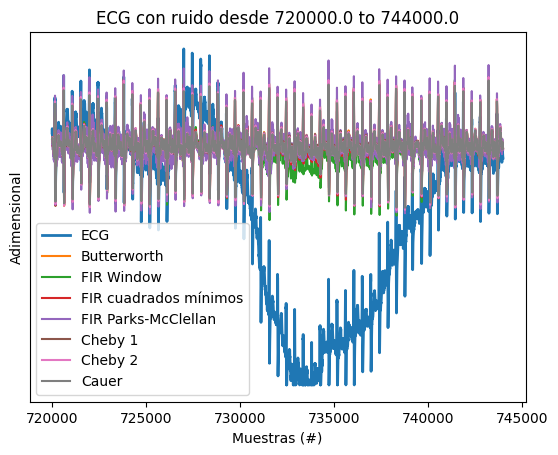

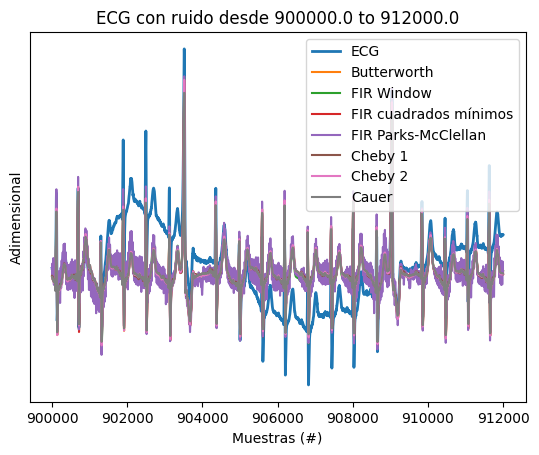

In [8]:
###################################
# Regiones de interés con ruido #
###################################
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_butter[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ecg_filt_win[zoom_region + retardo_win], label='FIR Window')
    plt.plot(zoom_region, ecg_filt_ls[zoom_region + retardo_ls], label='FIR cuadrados mínimos')
    plt.plot(zoom_region, ecg_filt_rem[zoom_region + retardo_rem], label='FIR Parks-McClellan')
    plt.plot(zoom_region, ecg_filt_cheby1[zoom_region], label='Cheby 1')
    plt.plot(zoom_region, ecg_filt_cheby2[zoom_region], label='Cheby 2')
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='Cauer')
    
    plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
    
    plt.show()

Así como en el caso de las zonas sin ruido, las zonas con ruido se eligieron de la misma manera. 

Se puede decir que, en base a los gráficos de forma general, el filtro Butterworth es muy estable, amortigua bien el ruido de alta frecuencia, a veces deja la línea base un poco elevada o con muy leve tendencia, no genera oscilaciones ni ringing, uno de los mejores comportamientos. El filtro FIR ventana: filtra de manera fuerte, tiende a aplanar partes importantes de la señal, se queda corto en amplitud en varios segmentos, en algunos tramos baja demasiado la onda, es el más suave pero también el que más distorsiona la forma. El filtro FIR cuadrados mínimos: tiene respuesta suave, poco ruido, conserva bastante bien la morfología de QRS y T, tiene menos oscilaciones que Parks-McClellan, es un buen balance entre suavizado y forma. El filtro FIR Parks-McClellan: se ve un "rippling" característico(pequeñas oscilaciones), filtra bien pero introduce ondulaciones cerca de los QRS, es típico del diseño equirrizado, no dostorsiona mucho pero se lo ve menos suave. Los filtros Chebyshev I y II: se comportan parecido, buen filtrado pero con ripples en la banda de paso o rechazo, a veces oscilan demasiado en los flancos del QRS, mantienen relativamente bien la amplitud. El filtro Cauer: tiene poco ruido, buena forma, transiciones rápidas, puede generar pequeñas ondulaciones por ser un filtro elíptico, en general es bastante eficiente. 

Para el gráfico 1: todos los filtros reducen bien el ruido; Parks-McClellan y Chebyshev muestran más oscilaciones; Butterworth y cuadrados mínimos parecen los más "limpios", FIR ventana se queda por debajo en amplitud.

Para el gráfico 2: Butterworth y cuadrados mínimos suavizan sin distorsionar; FIR ventana atenúa demasiado; Chebyshev y Parks-McClellan muestran ripple. 

Para el gráfico 3: con un QRS muy grande los mejores para este filtrado son Butterworth, cuadrados mínimos y Cauer, Chebyshev y Parks-McClellan oscilan y FIR ventana se queda corto en amplitud. 

El filtro Butterworth y el FIR por cuadrados mínimos presentan el mejor compromiso entre reducción de ruido y preservación de la forma del ECG.
El FIR con ventana es el que más suaviza pero distorsiona la amplitud.
Los filtros Chebyshev y Parks–McClellan introducen oscilaciones (ripples), especialmente alrededor de los QRS.
El Cauer ofrece buen filtrado pero con leves ondulaciones típicas de su diseño elíptico.

## Conclusiones